In [24]:
import torch
from torch import nn
from d2l import torch as d2l

## VGG块

In [25]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

## VGG-11

In [26]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    return nn.Sequential(
        *conv_blks,

        nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 4096), 
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(4096, 10)
    )

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
net = vgg(conv_arch)

X = torch.randn([1, 1, 224, 224])
for layer in net:
    X = layer(X)
    print(f'{layer.__class__.__name__} ->\t{X.shape}')

Sequential ->	torch.Size([1, 64, 112, 112])
Sequential ->	torch.Size([1, 128, 56, 56])
Sequential ->	torch.Size([1, 256, 28, 28])
Sequential ->	torch.Size([1, 512, 14, 14])
Sequential ->	torch.Size([1, 512, 7, 7])
Flatten ->	torch.Size([1, 25088])
Linear ->	torch.Size([1, 4096])
ReLU ->	torch.Size([1, 4096])
Dropout ->	torch.Size([1, 4096])
Linear ->	torch.Size([1, 4096])
ReLU ->	torch.Size([1, 4096])
Dropout ->	torch.Size([1, 4096])
Linear ->	torch.Size([1, 10])


loss 0.636, train acc 0.937, test acc 0.913
2733.4 examples/sec on cuda:1


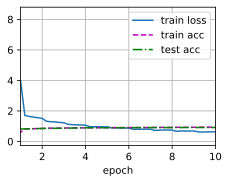

In [27]:
ratio = 4
small_conv_arch = [(pair[0], pair[1]//ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

# 训练
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

device = torch.device('cuda:1')
print('training on', device)
net.to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()

animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

timer, num_batches = d2l.Timer(), len(train_iter)

for epoch in range(num_epochs):
    metric = d2l.Accumulator(3)
    net.train()

    for i, (X, y) in enumerate(train_iter):
        timer.start()
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        
        y_hat = net(X)
        l = loss(y_hat, y)
        l.backward()
        optimizer.step()
        
        with torch.no_grad():
            metric.add(l*num_batches, d2l.accuracy(y_hat, y), X.shape[0])
        timer.stop()
        train_loss = metric[0] / metric[2]
        train_acc = metric[1] / metric[2]

        if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (train_loss, train_acc, None))

    test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')
print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(device)}')
